## Import Data

In [324]:
!ls .././data | sort

busstops_norway.csv
grunnkrets_age_distribution.csv
grunnkrets_households_num_persons.csv
grunnkrets_income_households.csv
grunnkrets_norway_stripped.csv
plaace_hierarchy.csv
sample_submission.csv
stores_extra.csv
stores_test.csv
stores_train.csv


## Libraries

In [325]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn import preprocessing

## Settings

In [326]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 25)
plt.figure(figsize=(9, 7))
plt.style.use('bmh')
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 50}

plt.rc('font', **font)

<Figure size 648x504 with 0 Axes>

## Import Files

In [327]:
stores_train = pd.read_csv('../data/stores_train.csv')
stores_test = pd.read_csv('../data/stores_test.csv')
stores_extra = pd.read_csv('../data/stores_extra.csv')
plaace_hierarchy = pd.read_csv('../data/plaace_hierarchy.csv')
grunnkrets = pd.read_csv('../data/grunnkrets_norway_stripped.csv')
grunnkrets_ages = pd.read_csv('../data/grunnkrets_age_distribution.csv')
grunnkrets_household_types = pd.read_csv('../data/grunnkrets_households_num_persons.csv')
grunnkrets_household_income = pd.read_csv('../data/grunnkrets_income_households.csv')
busstops = pd.read_csv('../data/busstops_norway.csv')

## RMSLE Function

In [328]:
def rmsle(y_true, y_pred):
    """
    Computes the Root Mean Squared Logarithmic Error 
    
    Args:
        y_true (np.array): n-dimensional vector of ground-truth values 
        y_pred (np.array): n-dimensional vecotr of predicted values 
    
    Returns:
        A scalar float with the rmsle value 
    
    Note: You can alternatively use sklearn and just do: 
        `sklearn.metrics.mean_squared_log_error(y_true, y_pred) ** 0.5`
    """
    assert (y_true >= 0).all(), 'Received negative y_true values'
    assert (y_pred >= 0).all(), 'Received negative y_pred values'
    assert y_true.shape == y_pred.shape, 'y_true and y_pred have different shapes'
    y_true_log1p = np.log1p(y_true)  # log(1 + y_true)
    y_pred_log1p = np.log1p(y_pred)  # log(1 + y_pred)
    return np.sqrt(np.mean(np.square(y_pred_log1p - y_true_log1p)))

# Merging all the Datasets

## Merging plaace_hierarchy with Stores data

In [329]:
# Augment stores_train with information about the hierarchy
stores_with_hierarchy = stores_train.merge(plaace_hierarchy, how='left', on='plaace_hierarchy_id')
stores_with_hierarchy_test = stores_test.merge(plaace_hierarchy, how='left', on='plaace_hierarchy_id')

# Show dataframe, but transposed so that we can more easily see all the resulting columns
stores_with_hierarchy.head()

,store_id,year,store_name,plaace_hierarchy_id,sales_channel_name_x,grunnkrets_id,address,lat,lon,chain_name,mall_name,revenue,sales_channel_name_y,lv1,lv1_desc,lv2,lv2_desc,lv3,lv3_desc,lv4,lv4_desc
0,983540538-974187930-44774,2016,MCDONALD'S BRAGERNES TORG MAGASINET,1.1.1.0,Hamburger restaurants,6020303,BRAGERNES TORG 13,59.743104,10.204928,MCDONALDS,Magasinet Drammen,17.998,Hamburger restaurants,1,Dining and Experiences,1.1,Restaurant,1.1.1,Hamburger restaurants,1.1.1.0,Hamburger restaurants
1,987074191-973117734-44755,2016,MCDONALD'S KLINGENBERGGATA,1.1.1.0,Hamburger restaurants,3010306,NaN,59.913759,10.734031,MCDONALDS,NaN,23.828,Hamburger restaurants,1,Dining and Experiences,1.1,Restaurant,1.1.1,Hamburger restaurants,1.1.1.0,Hamburger restaurants
2,984890265-981157303-64491,2016,BURGER KING HØNEFOSS,1.1.1.0,Hamburger restaurants,6050102,KONG RINGS GATE 1,60.164751,10.254656,BURGER KING,Kuben Hønefoss,16.099,Hamburger restaurants,1,Dining and Experiences,1.1,Restaurant,1.1.1,Hamburger restaurants,1.1.1.0,Hamburger restaurants
3,914057442-992924179-126912,2016,BURGER KING GLASSHUSPASSASJEN,1.1.1.0,Hamburger restaurants,18040102,STORGATA 12,67.283669,14.379796,BURGER KING,Glasshuspassasjen,9.296,Hamburger restaurants,1,Dining and Experiences,1.1,Restaurant,1.1.1,Hamburger restaurants,1.1.1.0,Hamburger restaurants
4,913018583-913063538-668469,2016,BURGER KING TILLERTORGET,1.1.1.0,Hamburger restaurants,16017414,NaN,63.358068,10.374832,BURGER KING,Tillertorget,4.528,Hamburger restaurants,1,Dining and Experiences,1.1,Restaurant,1.1.1,Hamburger restaurants,1.1.1.0,Hamburger restaurants


In [330]:
# Convert latitude, longitude to polar coordinates
def cartesian_to_polar_coordinates(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi)
    
geographical_weighted_center_latitude = np.average(stores_with_hierarchy["lat"])
geographical_weighted_center_longitude = np.average(stores_with_hierarchy["lon"])

delta_latitude = stores_with_hierarchy["lat"] - geographical_weighted_center_latitude
delta_longitude = stores_with_hierarchy["lon"] - geographical_weighted_center_longitude

stores_with_hierarchy["distance_from_center"], stores_with_hierarchy["angle"] = cartesian_to_polar_coordinates(delta_latitude, delta_longitude)


geographical_weighted_center_latitude = np.average(stores_with_hierarchy_test["lat"])
geographical_weighted_center_longitude = np.average(stores_with_hierarchy_test["lon"])

delta_latitude = stores_with_hierarchy_test["lat"] - geographical_weighted_center_latitude
delta_longitude = stores_with_hierarchy_test["lon"] - geographical_weighted_center_longitude

stores_with_hierarchy_test["distance_from_center"], stores_with_hierarchy_test["angle"] = cartesian_to_polar_coordinates(delta_latitude, delta_longitude)

## Merging Grunnkrets with Stores data

In [331]:
grunnkrets_2016 = grunnkrets.loc[grunnkrets['year'] == 2016]
stores_with_hierarchy_grunnkrets = pd.merge(stores_with_hierarchy, grunnkrets_2016, how='left', on='grunnkrets_id')
stores_with_hierarchy_grunnkrets_test = pd.merge(stores_with_hierarchy_test, grunnkrets_2016, how='left', on='grunnkrets_id')
stores_with_hierarchy_grunnkrets_test


,store_id,year_x,store_name,plaace_hierarchy_id,sales_channel_name_x,grunnkrets_id,address,lat,lon,chain_name,mall_name,sales_channel_name_y,lv1,lv1_desc,lv2,lv2_desc,lv3,lv3_desc,lv4,lv4_desc,distance_from_center,angle,year_y,grunnkrets_name,district_name,municipality_name,geometry,area_km2
0,914206820-914239427-717245,2016,VÅLERENGA HALAL BURGER AS,1.1.1.0,Hamburger restaurants,3012704,STRØMSVEIEN 25 A,59.908672,10.787031,NaN,NaN,Hamburger restaurants,1,Dining and Experiences,1.1,Restaurant,1.1.1,Hamburger restaurants,1.1.1.0,Hamburger restaurants,1.530048,2.634062,2016.0,Vålerenga rode 4,Vålerenga,Oslo,"POLYGON((10.7867135984557 59.908762574244, 10....",0.057027
1,916789157-916823770-824309,2016,BURGER KING MYREN,1.1.1.0,Hamburger restaurants,8061401,MYREN 1,59.201467,9.588243,BURGER KING,NaN,Hamburger restaurants,1,Dining and Experiences,1.1,Restaurant,1.1.1,Hamburger restaurants,1.1.1.0,Hamburger restaurants,2.094441,-2.922530,2016.0,Kjempa,Gulset,Skien,MULTIPOLYGON(((9.57990302232997 59.20175739826...,0.165993
2,913341082-977479363-2948,2016,BURGER KING STOVNER,1.1.1.0,Hamburger restaurants,3013917,STOVNER SENTER 3,59.962146,10.924524,BURGER KING,Stovner Senter,Hamburger restaurants,1,Dining and Experiences,1.1,Restaurant,1.1.1,Hamburger restaurants,1.1.1.0,Hamburger restaurants,1.557014,2.540058,2016.0,Stovner senter,Fossum,Oslo,"POLYGON((10.9327714172545 59.9614144471754, 10...",0.236628
3,889682582-889697172-28720,2016,BURGER KING TUNGASLETTA,1.1.1.0,Hamburger restaurants,16012104,TUNGASLETTA 16,63.420785,10.461091,BURGER KING,NaN,Hamburger restaurants,1,Dining and Experiences,1.1,Restaurant,1.1.1,Hamburger restaurants,1.1.1.0,Hamburger restaurants,2.214677,0.189739,2016.0,Strindheim 4,Strindheim,Trondheim,"POLYGON((10.459001199372 63.424320840557, 10.4...",0.983436
4,997991699-998006945-417222,2016,VULKAN BURGERBAR,1.1.1.0,Hamburger restaurants,3014305,AUD SCHØNEMANNS VEI 15,59.921102,10.785123,VULKAN BURGERBAR,NaN,Hamburger restaurants,1,Dining and Experiences,1.1,Restaurant,1.1.1,Hamburger restaurants,1.1.1.0,Hamburger restaurants,1.518264,2.631182,2016.0,Lille Tøyen,Hasle,Oslo,"POLYGON((10.7815720596407 59.9175770831722, 10...",0.449502
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8572,917323003-917383529-844309,2016,GULATING HAUGESUND,2.8.11.2,Beer and soda shop,11490601,BRÅTAVEGEN 30,59.259575,5.325813,GULATING GRUPPEN,NaN,Beer and soda shop,2,Retail,2.8,Food and drinks,2.8.11,Alcohol sales,2.8.11.2,Beer and soda shop,5.118681,-1.969306,2016.0,Stokkastrand,Kopervik,Karmøy,MULTIPOLYGON(((5.32136787489711 59.23099432230...,1.708924
8573,917353379-917411824-845904,2016,STAVANGER BEER AS,2.8.11.2,Beer and soda shop,11030901,SANDVIGÅ 7,58.976219,5.721546,NaN,NaN,Beer and soda shop,2,Retail,2.8,Food and drinks,2.8.11,Alcohol sales,2.8.11.2,Beer and soda shop,4.881560,-2.054364,2016.0,Bjergsted,Kampen,Stavanger,"POLYGON((5.72714116927016 58.9724047824004, 5....",0.310575
8574,917072302-917089248-833647,2016,GULATING ØLUTSALG OG PUB,2.8.11.2,Beer and soda shop,2270103,GARDERBAKKEN 6,59.928330,11.163202,GULATING GRUPPEN,NaN,Beer and soda shop,2,Retail,2.8,Food and drinks,2.8.11,Alcohol sales,2.8.11.2,Beer and soda shop,1.729114,2.437138,2016.0,Fetsund,Hovinhøgda,Fet,"POLYGON((11.1631232250592 59.9379356074191, 11...",1.627789
8575,916960557-916993161-829908,2016,VI BRYGGER BUTIKKDRIFT AS,2.8.11.2,Beer and soda shop,12470701,RAVNANGERVEGEN,60.445790,5.161587,NaN,NaN,Beer and soda shop,2,Retail,2.8,Food and drinks,2.8.11,Alcohol sales,2.8.11.2,Beer and soda shop,4.946935,-1.733239,2016.0,Haugland,Haugland/Davanger/Ramsøy,Askøy,MULTIPOLYGON(((5.18520140772538 60.44242290291...,1.103012


In [332]:
grunnkrets_ages
grunnkrets_ages_2016 = grunnkrets_ages.loc[grunnkrets_ages['year'] == 2016]
stores_with_hierarchy_grunnkrets_age = pd.merge(stores_with_hierarchy_grunnkrets, grunnkrets_ages_2016, how='left', on='grunnkrets_id')
stores_with_hierarchy_grunnkrets_age_test = pd.merge(stores_with_hierarchy_grunnkrets_test, grunnkrets_ages_2016, how='left', on='grunnkrets_id')
stores_with_hierarchy_grunnkrets_age

# Feature engineering: Age binning
under_18 = grunnkrets_ages.loc[: , "age_0":"age_18"]
above_18 = grunnkrets_ages.loc[: , "age_19":"age_90"]
grunnkrets_ages['0_to_18'] = under_18.sum(axis = 1)
grunnkrets_ages['19_to_90'] = above_18.sum(axis = 1)
grunnkrets_ages = grunnkrets_ages.drop(grunnkrets_ages.iloc[:, 2:93],axis = 1) # drop age columns

grunnkrets_ages_2016 = grunnkrets_ages.loc[grunnkrets_ages['year'] == 2016]
stores_with_hierarchy_grunnkrets_age = pd.merge(stores_with_hierarchy_grunnkrets, grunnkrets_ages_2016, how='left', on='grunnkrets_id')
stores_with_hierarchy_grunnkrets_age_test = pd.merge(stores_with_hierarchy_grunnkrets_test, grunnkrets_ages_2016, how='left', on='grunnkrets_id')
stores_with_hierarchy_grunnkrets_age['0_to_18'] = stores_with_hierarchy_grunnkrets_age['0_to_18'].fillna((stores_with_hierarchy_grunnkrets_age['0_to_18'].mean()))
stores_with_hierarchy_grunnkrets_age['19_to_90'] = stores_with_hierarchy_grunnkrets_age['19_to_90'].fillna((stores_with_hierarchy_grunnkrets_age['19_to_90'].mean()))


In [333]:
grunnkrets_household_types
grunnkrets_household_types_2016 = grunnkrets_household_types.loc[grunnkrets_household_types['year'] == 2016]
stores_with_hierarchy_grunnkrets_age_hhtypes = pd.merge(stores_with_hierarchy_grunnkrets_age, grunnkrets_household_types_2016, how='left', on='grunnkrets_id')
stores_with_hierarchy_grunnkrets_age_hhtypes_test = pd.merge(stores_with_hierarchy_grunnkrets_age_test, grunnkrets_household_types_2016, how='left', on='grunnkrets_id')

stores_with_hierarchy_grunnkrets_age_hhtypes


,store_id,year_x,store_name,plaace_hierarchy_id,sales_channel_name_x,grunnkrets_id,address,lat,lon,chain_name,mall_name,revenue,sales_channel_name_y,lv1,lv1_desc,lv2,lv2_desc,lv3,lv3_desc,lv4,lv4_desc,distance_from_center,angle,year_y,grunnkrets_name,district_name,municipality_name,geometry,area_km2,year_x,0_to_18,19_to_90,year_y,couple_children_0_to_5_years,couple_children_18_or_above,couple_children_6_to_17_years,couple_without_children,single_parent_children_0_to_5_years,single_parent_children_18_or_above,single_parent_children_6_to_17_years,singles
0,983540538-974187930-44774,2016,MCDONALD'S BRAGERNES TORG MAGASINET,1.1.1.0,Hamburger restaurants,6020303,BRAGERNES TORG 13,59.743104,10.204928,MCDONALDS,Magasinet Drammen,17.998,Hamburger restaurants,1,Dining and Experiences,1.1,Restaurant,1.1.1,Hamburger restaurants,1.1.1.0,Hamburger restaurants,1.483925,2.999938,2016.0,Bragernes sentrum 3,Bragernes sentrum,Drammen,"POLYGON((10.2046156903846 59.7447808519649, 10...",0.155779,2016.0,25.000000,132.000000,2016.0,20.0,0.0,8.0,28.0,4.0,6.0,11.0,75.0
1,987074191-973117734-44755,2016,MCDONALD'S KLINGENBERGGATA,1.1.1.0,Hamburger restaurants,3010306,NaN,59.913759,10.734031,MCDONALDS,NaN,23.828,Hamburger restaurants,1,Dining and Experiences,1.1,Restaurant,1.1.1,Hamburger restaurants,1.1.1.0,Hamburger restaurants,1.493786,2.624389,2016.0,Sentrum 3 /rode 6,Sentrum 3,Oslo,"POLYGON((10.7303654475615 59.9107195782207, 10...",0.264278,NaN,143.178518,622.172205,2016.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
2,984890265-981157303-64491,2016,BURGER KING HØNEFOSS,1.1.1.0,Hamburger restaurants,6050102,KONG RINGS GATE 1,60.164751,10.254656,BURGER KING,Kuben Hønefoss,16.099,Hamburger restaurants,1,Dining and Experiences,1.1,Restaurant,1.1.1,Hamburger restaurants,1.1.1.0,Hamburger restaurants,1.079018,2.898973,2016.0,Sydsiden 2,Hønefoss,Ringerike,"POLYGON((10.2654039198422 60.1639238060368, 10...",0.160152,2016.0,67.000000,305.000000,2016.0,45.0,9.0,38.0,84.0,13.0,6.0,12.0,150.0
3,914057442-992924179-126912,2016,BURGER KING GLASSHUSPASSASJEN,1.1.1.0,Hamburger restaurants,18040102,STORGATA 12,67.283669,14.379796,BURGER KING,Glasshuspassasjen,9.296,Hamburger restaurants,1,Dining and Experiences,1.1,Restaurant,1.1.1,Hamburger restaurants,1.1.1.0,Hamburger restaurants,7.489049,0.625420,2016.0,Sentrum 1,Sentrum,Bodø,"POLYGON((14.3800126797167 67.2852351710009, 14...",0.095029,2016.0,46.000000,428.000000,2016.0,41.0,10.0,27.0,126.0,11.0,8.0,15.0,254.0
4,913018583-913063538-668469,2016,BURGER KING TILLERTORGET,1.1.1.0,Hamburger restaurants,16017414,NaN,63.358068,10.374832,BURGER KING,Tillertorget,4.528,Hamburger restaurants,1,Dining and Experiences,1.1,Restaurant,1.1.1,Hamburger restaurants,1.1.1.0,Hamburger restaurants,2.179184,0.174997,2016.0,Tiller-Hårstad 14,Tiller-Hårstad,Trondheim,"POLYGON((10.3709720705149 63.3579302939404, 10...",0.251070,NaN,143.178518,622.172205,2016.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12854,915789943-915806929-781991,2016,MEIERIGÅRDEN BRYGGERIUTSALG,2.8.11.2,Beer and soda shop,7010705,THUEGATA 2,59.416276,10.480970,NaN,NaN,0.088,Beer and soda shop,2,Retail,2.8,Food and drinks,2.8.11,Alcohol sales,2.8.11.2,Beer and soda shop,1.860369,2.877541,2016.0,Sentrum,Sentrum,Horten,"POLYGON((10.4844343691104 59.4185964815712, 10...",0.291337,2016.0,194.000000,1322.000000,2016.0,159.0,53.0,113.0,488.0,46.0,36.0,58.0,556.0
12855,917921733-917982368-868081,2016,GULATING ØLUTSALG CC GJØVIK,2.8.11.2,Beer and soda shop,5020406,NaN,60.799991,10.693635,GULATING GRUPPEN,CC Gjøvik,1.816,Beer and soda shop,2,Retail,2.8,Food and drinks,2.8.11,Alcohol sales,2.8.11.2,Beer and soda shop,0.810793,2.104077,2016.0,Sentrum 6,Sentrum,Gjøvik,"POLYGON((10.6971768573538 60.7988198867219, 10...",0.137188,2016.0,42.000000,461.000000,2016.0,47.0,9.0,14.0,138.0,5.0,7.0,19.0,256.0
12856,911721961-911764474-49676

In [334]:
grunnkrets_household_income
grunnkrets_household_income_2016 = grunnkrets_household_income.loc[grunnkrets_household_income['year'] == 2016]
stores_with_hierarchy_grunnkrets_age_hhtypes_hhincome = pd.merge(stores_with_hierarchy_grunnkrets_age_hhtypes, grunnkrets_household_income_2016, how='left', on='grunnkrets_id')
stores_with_hierarchy_grunnkrets_age_hhtypes_hhincome_test = pd.merge(stores_with_hierarchy_grunnkrets_age_hhtypes_test, grunnkrets_household_income_2016, how='left', on='grunnkrets_id')

stores_with_hierarchy_grunnkrets_age_hhtypes_hhincome


,store_id,year_x,store_name,plaace_hierarchy_id,sales_channel_name_x,grunnkrets_id,address,lat,lon,chain_name,mall_name,revenue,sales_channel_name_y,lv1,lv1_desc,lv2,lv2_desc,lv3,lv3_desc,lv4,lv4_desc,distance_from_center,angle,year_y,grunnkrets_name,district_name,municipality_name,geometry,area_km2,year_x,0_to_18,19_to_90,year_y,couple_children_0_to_5_years,couple_children_18_or_above,couple_children_6_to_17_years,couple_without_children_x,single_parent_children_0_to_5_years,single_parent_children_18_or_above,single_parent_children_6_to_17_years,singles_x,year,all_households,singles_y,couple_without_children_y,couple_with_children,other_households,single_parent_with_children
0,983540538-974187930-44774,2016,MCDONALD'S BRAGERNES TORG MAGASINET,1.1.1.0,Hamburger restaurants,6020303,BRAGERNES TORG 13,59.743104,10.204928,MCDONALDS,Magasinet Drammen,17.998,Hamburger restaurants,1,Dining and Experiences,1.1,Restaurant,1.1.1,Hamburger restaurants,1.1.1.0,Hamburger restaurants,1.483925,2.999938,2016.0,Bragernes sentrum 3,Bragernes sentrum,Drammen,"POLYGON((10.2046156903846 59.7447808519649, 10...",0.155779,2016.0,25.000000,132.000000,2016.0,20.0,0.0,8.0,28.0,4.0,6.0,11.0,75.0,2016.0,398700.0,277500.0,669100.0,832800.0,679600.0,349500.0
1,987074191-973117734-44755,2016,MCDONALD'S KLINGENBERGGATA,1.1.1.0,Hamburger restaurants,3010306,NaN,59.913759,10.734031,MCDONALDS,NaN,23.828,Hamburger restaurants,1,Dining and Experiences,1.1,Restaurant,1.1.1,Hamburger restaurants,1.1.1.0,Hamburger restaurants,1.493786,2.624389,2016.0,Sentrum 3 /rode 6,Sentrum 3,Oslo,"POLYGON((10.7303654475615 59.9107195782207, 10...",0.264278,NaN,143.178518,622.172205,2016.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,2016.0,374800.0,295000.0,679600.0,802200.0,604100.0,397700.0
2,984890265-981157303-64491,2016,BURGER KING HØNEFOSS,1.1.1.0,Hamburger restaurants,6050102,KONG RINGS GATE 1,60.164751,10.254656,BURGER KING,Kuben Hønefoss,16.099,Hamburger restaurants,1,Dining and Experiences,1.1,Restaurant,1.1.1,Hamburger restaurants,1.1.1.0,Hamburger restaurants,1.079018,2.898973,2016.0,Sydsiden 2,Hønefoss,Ringerike,"POLYGON((10.2654039198422 60.1639238060368, 10...",0.160152,2016.0,67.000000,305.000000,2016.0,45.0,9.0,38.0,84.0,13.0,6.0,12.0,150.0,2016.0,347900.0,251900.0,589900.0,673100.0,637600.0,327000.0
3,914057442-992924179-126912,2016,BURGER KING GLASSHUSPASSASJEN,1.1.1.0,Hamburger restaurants,18040102,STORGATA 12,67.283669,14.379796,BURGER KING,Glasshuspassasjen,9.296,Hamburger restaurants,1,Dining and Experiences,1.1,Restaurant,1.1.1,Hamburger restaurants,1.1.1.0,Hamburger restaurants,7.489049,0.625420,2016.0,Sentrum 1,Sentrum,Bodø,"POLYGON((14.3800126797167 67.2852351710009, 14...",0.095029,2016.0,46.000000,428.000000,2016.0,41.0,10.0,27.0,126.0,11.0,8.0,15.0,254.0,2016.0,394000.0,293600.0,602000.0,675800.0,699600.0,335200.0
4,913018583-913063538-668469,2016,BURGER KING TILLERTORGET,1.1.1.0,Hamburger restaurants,16017414,NaN,63.358068,10.374832,BURGER KING,Tillertorget,4.528,Hamburger restaurants,1,Dining and Experiences,1.1,Restaurant,1.1.1,Hamburger restaurants,1.1.1.0,Hamburger restaurants,2.179184,0.174997,2016.0,Tiller-Hårstad 14,Tiller-Hårstad,Trondheim,"POLYGON((10.3709720705149 63.3579302939404, 10...",0.251070,NaN,143.178518,622.172205,2016.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2016.0,623700.0,296500.0,635700.0,779700.0,801300.0,413600.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12854,915789943-915806929-781991,2016,MEIERIGÅRDEN BRYGGERIUTSALG,2.8.11.2,Beer and soda shop,7010705,THUEGATA 2,59.416276,10.480970,NaN,NaN,0.088,Beer and soda shop,2,Retail,2.8,Food and drinks,2.8.11,Alcohol sales,2.8.11.2,Beer and soda shop,1.860369,2.877541,2016.0,Sentrum,Sentrum,Horten,"POLYGON((10.4844343691104 59.4185964815712, 10...",0.291337,2016.0,194.000000,1322.000000,2016.0,159.0,53.0,113.0,488.0,46.0,36.0,58.0,556.0,2016.0,381900

In [335]:
stores_train_merged = stores_with_hierarchy_grunnkrets_age_hhtypes_hhincome
stores_test_merged = stores_with_hierarchy_grunnkrets_age_hhtypes_hhincome_test
stores_train_merged

,store_id,year_x,store_name,plaace_hierarchy_id,sales_channel_name_x,grunnkrets_id,address,lat,lon,chain_name,mall_name,revenue,sales_channel_name_y,lv1,lv1_desc,lv2,lv2_desc,lv3,lv3_desc,lv4,lv4_desc,distance_from_center,angle,year_y,grunnkrets_name,district_name,municipality_name,geometry,area_km2,year_x,0_to_18,19_to_90,year_y,couple_children_0_to_5_years,couple_children_18_or_above,couple_children_6_to_17_years,couple_without_children_x,single_parent_children_0_to_5_years,single_parent_children_18_or_above,single_parent_children_6_to_17_years,singles_x,year,all_households,singles_y,couple_without_children_y,couple_with_children,other_households,single_parent_with_children
0,983540538-974187930-44774,2016,MCDONALD'S BRAGERNES TORG MAGASINET,1.1.1.0,Hamburger restaurants,6020303,BRAGERNES TORG 13,59.743104,10.204928,MCDONALDS,Magasinet Drammen,17.998,Hamburger restaurants,1,Dining and Experiences,1.1,Restaurant,1.1.1,Hamburger restaurants,1.1.1.0,Hamburger restaurants,1.483925,2.999938,2016.0,Bragernes sentrum 3,Bragernes sentrum,Drammen,"POLYGON((10.2046156903846 59.7447808519649, 10...",0.155779,2016.0,25.000000,132.000000,2016.0,20.0,0.0,8.0,28.0,4.0,6.0,11.0,75.0,2016.0,398700.0,277500.0,669100.0,832800.0,679600.0,349500.0
1,987074191-973117734-44755,2016,MCDONALD'S KLINGENBERGGATA,1.1.1.0,Hamburger restaurants,3010306,NaN,59.913759,10.734031,MCDONALDS,NaN,23.828,Hamburger restaurants,1,Dining and Experiences,1.1,Restaurant,1.1.1,Hamburger restaurants,1.1.1.0,Hamburger restaurants,1.493786,2.624389,2016.0,Sentrum 3 /rode 6,Sentrum 3,Oslo,"POLYGON((10.7303654475615 59.9107195782207, 10...",0.264278,NaN,143.178518,622.172205,2016.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,2016.0,374800.0,295000.0,679600.0,802200.0,604100.0,397700.0
2,984890265-981157303-64491,2016,BURGER KING HØNEFOSS,1.1.1.0,Hamburger restaurants,6050102,KONG RINGS GATE 1,60.164751,10.254656,BURGER KING,Kuben Hønefoss,16.099,Hamburger restaurants,1,Dining and Experiences,1.1,Restaurant,1.1.1,Hamburger restaurants,1.1.1.0,Hamburger restaurants,1.079018,2.898973,2016.0,Sydsiden 2,Hønefoss,Ringerike,"POLYGON((10.2654039198422 60.1639238060368, 10...",0.160152,2016.0,67.000000,305.000000,2016.0,45.0,9.0,38.0,84.0,13.0,6.0,12.0,150.0,2016.0,347900.0,251900.0,589900.0,673100.0,637600.0,327000.0
3,914057442-992924179-126912,2016,BURGER KING GLASSHUSPASSASJEN,1.1.1.0,Hamburger restaurants,18040102,STORGATA 12,67.283669,14.379796,BURGER KING,Glasshuspassasjen,9.296,Hamburger restaurants,1,Dining and Experiences,1.1,Restaurant,1.1.1,Hamburger restaurants,1.1.1.0,Hamburger restaurants,7.489049,0.625420,2016.0,Sentrum 1,Sentrum,Bodø,"POLYGON((14.3800126797167 67.2852351710009, 14...",0.095029,2016.0,46.000000,428.000000,2016.0,41.0,10.0,27.0,126.0,11.0,8.0,15.0,254.0,2016.0,394000.0,293600.0,602000.0,675800.0,699600.0,335200.0
4,913018583-913063538-668469,2016,BURGER KING TILLERTORGET,1.1.1.0,Hamburger restaurants,16017414,NaN,63.358068,10.374832,BURGER KING,Tillertorget,4.528,Hamburger restaurants,1,Dining and Experiences,1.1,Restaurant,1.1.1,Hamburger restaurants,1.1.1.0,Hamburger restaurants,2.179184,0.174997,2016.0,Tiller-Hårstad 14,Tiller-Hårstad,Trondheim,"POLYGON((10.3709720705149 63.3579302939404, 10...",0.251070,NaN,143.178518,622.172205,2016.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2016.0,623700.0,296500.0,635700.0,779700.0,801300.0,413600.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12854,915789943-915806929-781991,2016,MEIERIGÅRDEN BRYGGERIUTSALG,2.8.11.2,Beer and soda shop,7010705,THUEGATA 2,59.416276,10.480970,NaN,NaN,0.088,Beer and soda shop,2,Retail,2.8,Food and drinks,2.8.11,Alcohol sales,2.8.11.2,Beer and soda shop,1.860369,2.877541,2016.0,Sentrum,Sentrum,Horten,"POLYGON((10.4844343691104 59.4185964815712, 10...",0.291337,2016.0,194.000000,1322.000000,2016.0,159.0,53.0,113.0,488.0,46.0,36.0,58.0,556.0,2016.0,381900

# Exploratory Data Analysis

In [336]:
df = stores_train_merged
df

,store_id,year_x,store_name,plaace_hierarchy_id,sales_channel_name_x,grunnkrets_id,address,lat,lon,chain_name,mall_name,revenue,sales_channel_name_y,lv1,lv1_desc,lv2,lv2_desc,lv3,lv3_desc,lv4,lv4_desc,distance_from_center,angle,year_y,grunnkrets_name,district_name,municipality_name,geometry,area_km2,year_x,0_to_18,19_to_90,year_y,couple_children_0_to_5_years,couple_children_18_or_above,couple_children_6_to_17_years,couple_without_children_x,single_parent_children_0_to_5_years,single_parent_children_18_or_above,single_parent_children_6_to_17_years,singles_x,year,all_households,singles_y,couple_without_children_y,couple_with_children,other_households,single_parent_with_children
0,983540538-974187930-44774,2016,MCDONALD'S BRAGERNES TORG MAGASINET,1.1.1.0,Hamburger restaurants,6020303,BRAGERNES TORG 13,59.743104,10.204928,MCDONALDS,Magasinet Drammen,17.998,Hamburger restaurants,1,Dining and Experiences,1.1,Restaurant,1.1.1,Hamburger restaurants,1.1.1.0,Hamburger restaurants,1.483925,2.999938,2016.0,Bragernes sentrum 3,Bragernes sentrum,Drammen,"POLYGON((10.2046156903846 59.7447808519649, 10...",0.155779,2016.0,25.000000,132.000000,2016.0,20.0,0.0,8.0,28.0,4.0,6.0,11.0,75.0,2016.0,398700.0,277500.0,669100.0,832800.0,679600.0,349500.0
1,987074191-973117734-44755,2016,MCDONALD'S KLINGENBERGGATA,1.1.1.0,Hamburger restaurants,3010306,NaN,59.913759,10.734031,MCDONALDS,NaN,23.828,Hamburger restaurants,1,Dining and Experiences,1.1,Restaurant,1.1.1,Hamburger restaurants,1.1.1.0,Hamburger restaurants,1.493786,2.624389,2016.0,Sentrum 3 /rode 6,Sentrum 3,Oslo,"POLYGON((10.7303654475615 59.9107195782207, 10...",0.264278,NaN,143.178518,622.172205,2016.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,2016.0,374800.0,295000.0,679600.0,802200.0,604100.0,397700.0
2,984890265-981157303-64491,2016,BURGER KING HØNEFOSS,1.1.1.0,Hamburger restaurants,6050102,KONG RINGS GATE 1,60.164751,10.254656,BURGER KING,Kuben Hønefoss,16.099,Hamburger restaurants,1,Dining and Experiences,1.1,Restaurant,1.1.1,Hamburger restaurants,1.1.1.0,Hamburger restaurants,1.079018,2.898973,2016.0,Sydsiden 2,Hønefoss,Ringerike,"POLYGON((10.2654039198422 60.1639238060368, 10...",0.160152,2016.0,67.000000,305.000000,2016.0,45.0,9.0,38.0,84.0,13.0,6.0,12.0,150.0,2016.0,347900.0,251900.0,589900.0,673100.0,637600.0,327000.0
3,914057442-992924179-126912,2016,BURGER KING GLASSHUSPASSASJEN,1.1.1.0,Hamburger restaurants,18040102,STORGATA 12,67.283669,14.379796,BURGER KING,Glasshuspassasjen,9.296,Hamburger restaurants,1,Dining and Experiences,1.1,Restaurant,1.1.1,Hamburger restaurants,1.1.1.0,Hamburger restaurants,7.489049,0.625420,2016.0,Sentrum 1,Sentrum,Bodø,"POLYGON((14.3800126797167 67.2852351710009, 14...",0.095029,2016.0,46.000000,428.000000,2016.0,41.0,10.0,27.0,126.0,11.0,8.0,15.0,254.0,2016.0,394000.0,293600.0,602000.0,675800.0,699600.0,335200.0
4,913018583-913063538-668469,2016,BURGER KING TILLERTORGET,1.1.1.0,Hamburger restaurants,16017414,NaN,63.358068,10.374832,BURGER KING,Tillertorget,4.528,Hamburger restaurants,1,Dining and Experiences,1.1,Restaurant,1.1.1,Hamburger restaurants,1.1.1.0,Hamburger restaurants,2.179184,0.174997,2016.0,Tiller-Hårstad 14,Tiller-Hårstad,Trondheim,"POLYGON((10.3709720705149 63.3579302939404, 10...",0.251070,NaN,143.178518,622.172205,2016.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2016.0,623700.0,296500.0,635700.0,779700.0,801300.0,413600.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12854,915789943-915806929-781991,2016,MEIERIGÅRDEN BRYGGERIUTSALG,2.8.11.2,Beer and soda shop,7010705,THUEGATA 2,59.416276,10.480970,NaN,NaN,0.088,Beer and soda shop,2,Retail,2.8,Food and drinks,2.8.11,Alcohol sales,2.8.11.2,Beer and soda shop,1.860369,2.877541,2016.0,Sentrum,Sentrum,Horten,"POLYGON((10.4844343691104 59.4185964815712, 10...",0.291337,2016.0,194.000000,1322.000000,2016.0,159.0,53.0,113.0,488.0,46.0,36.0,58.0,556.0,2016.0,381900

In [337]:
# Ignore first
# s = df.pop('revenue') 
# new_df = pd.concat([df, s], 1)
# new_df
new_df = df

### Seperate the data set into numerical and categorical data

In [338]:
df_numerical_features = new_df.select_dtypes(exclude='object')
df_categorical_features = new_df.select_dtypes(include='object')
df_numerical_features

,year_x,grunnkrets_id,lat,lon,revenue,lv1,lv2,distance_from_center,angle,year_y,area_km2,year_x,0_to_18,19_to_90,year_y,couple_children_0_to_5_years,couple_children_18_or_above,couple_children_6_to_17_years,couple_without_children_x,single_parent_children_0_to_5_years,single_parent_children_18_or_above,single_parent_children_6_to_17_years,singles_x,year,all_households,singles_y,couple_without_children_y,couple_with_children,other_households,single_parent_with_children
0,2016,6020303,59.743104,10.204928,17.998,1,1.1,1.483925,2.999938,2016.0,0.155779,2016.0,25.000000,132.000000,2016.0,20.0,0.0,8.0,28.0,4.0,6.0,11.0,75.0,2016.0,398700.0,277500.0,669100.0,832800.0,679600.0,349500.0
1,2016,3010306,59.913759,10.734031,23.828,1,1.1,1.493786,2.624389,2016.0,0.264278,NaN,143.178518,622.172205,2016.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,2016.0,374800.0,295000.0,679600.0,802200.0,604100.0,397700.0
2,2016,6050102,60.164751,10.254656,16.099,1,1.1,1.079018,2.898973,2016.0,0.160152,2016.0,67.000000,305.000000,2016.0,45.0,9.0,38.0,84.0,13.0,6.0,12.0,150.0,2016.0,347900.0,251900.0,589900.0,673100.0,637600.0,327000.0
3,2016,18040102,67.283669,14.379796,9.296,1,1.1,7.489049,0.625420,2016.0,0.095029,2016.0,46.000000,428.000000,2016.0,41.0,10.0,27.0,126.0,11.0,8.0,15.0,254.0,2016.0,394000.0,293600.0,602000.0,675800.0,699600.0,335200.0
4,2016,16017414,63.358068,10.374832,4.528,1,1.1,2.179184,0.174997,2016.0,0.251070,NaN,143.178518,622.172205,2016.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2016.0,623700.0,296500.0,635700.0,779700.0,801300.0,413600.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12854,2016,7010705,59.416276,10.480970,0.088,2,2.8,1.860369,2.877541,2016.0,0.291337,2016.0,194.000000,1322.000000,2016.0,159.0,53.0,113.0,488.0,46.0,36.0,58.0,556.0,2016.0,381900.0,263600.0,563700.0,682000.0,636800.0,382100.0
12855,2016,5020406,60.799991,10.693635,1.816,2,2.8,0.810793,2.104077,2016.0,0.137188,2016.0,42.000000,461.000000,2016.0,47.0,9.0,14.0,138.0,5.0,7.0,19.0,256.0,2016.0,292000.0,243200.0,457800.0,465300.0,477700.0,339200.0
12856,2016,2310803,59.946562,11.007659,38.225,2,2.8,1.620608,2.466972,2016.0,0.123431,2016.0,145.000000,972.000000,2016.0,147.0,30.0,76.0,332.0,50.0,30.0,33.0,407.0,2016.0,440200.0,286200.0,595100.0,759300.0,745200.0,359800.0
12857,2016,11020113,58.850261,5.735674,3.642,2,2.8,4.870736,-2.077065,2016.0,0.034857,2016.0,22.000000,259.000000,2016.0,22.0,0.0,7.0,86.0,6.0,0.0,10.0,114.0,2016.0,382400.0,282700.0,597500.0,601500.0,649900.0,361700.0


## Distribution of Revenue

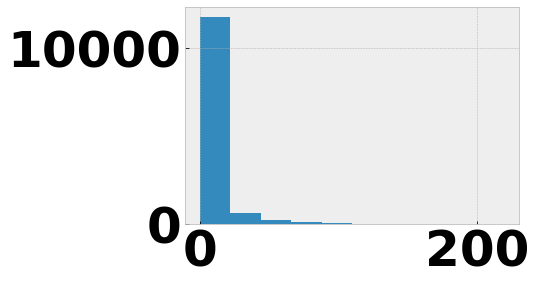

In [73]:
# plt.figure(figsize=(9, 7))
# sns.distplot(df['revenue'], color='g', bins=100, hist_kws={'alpha': 0.4});
df['revenue'].hist()

## Numerical Data Distribution

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


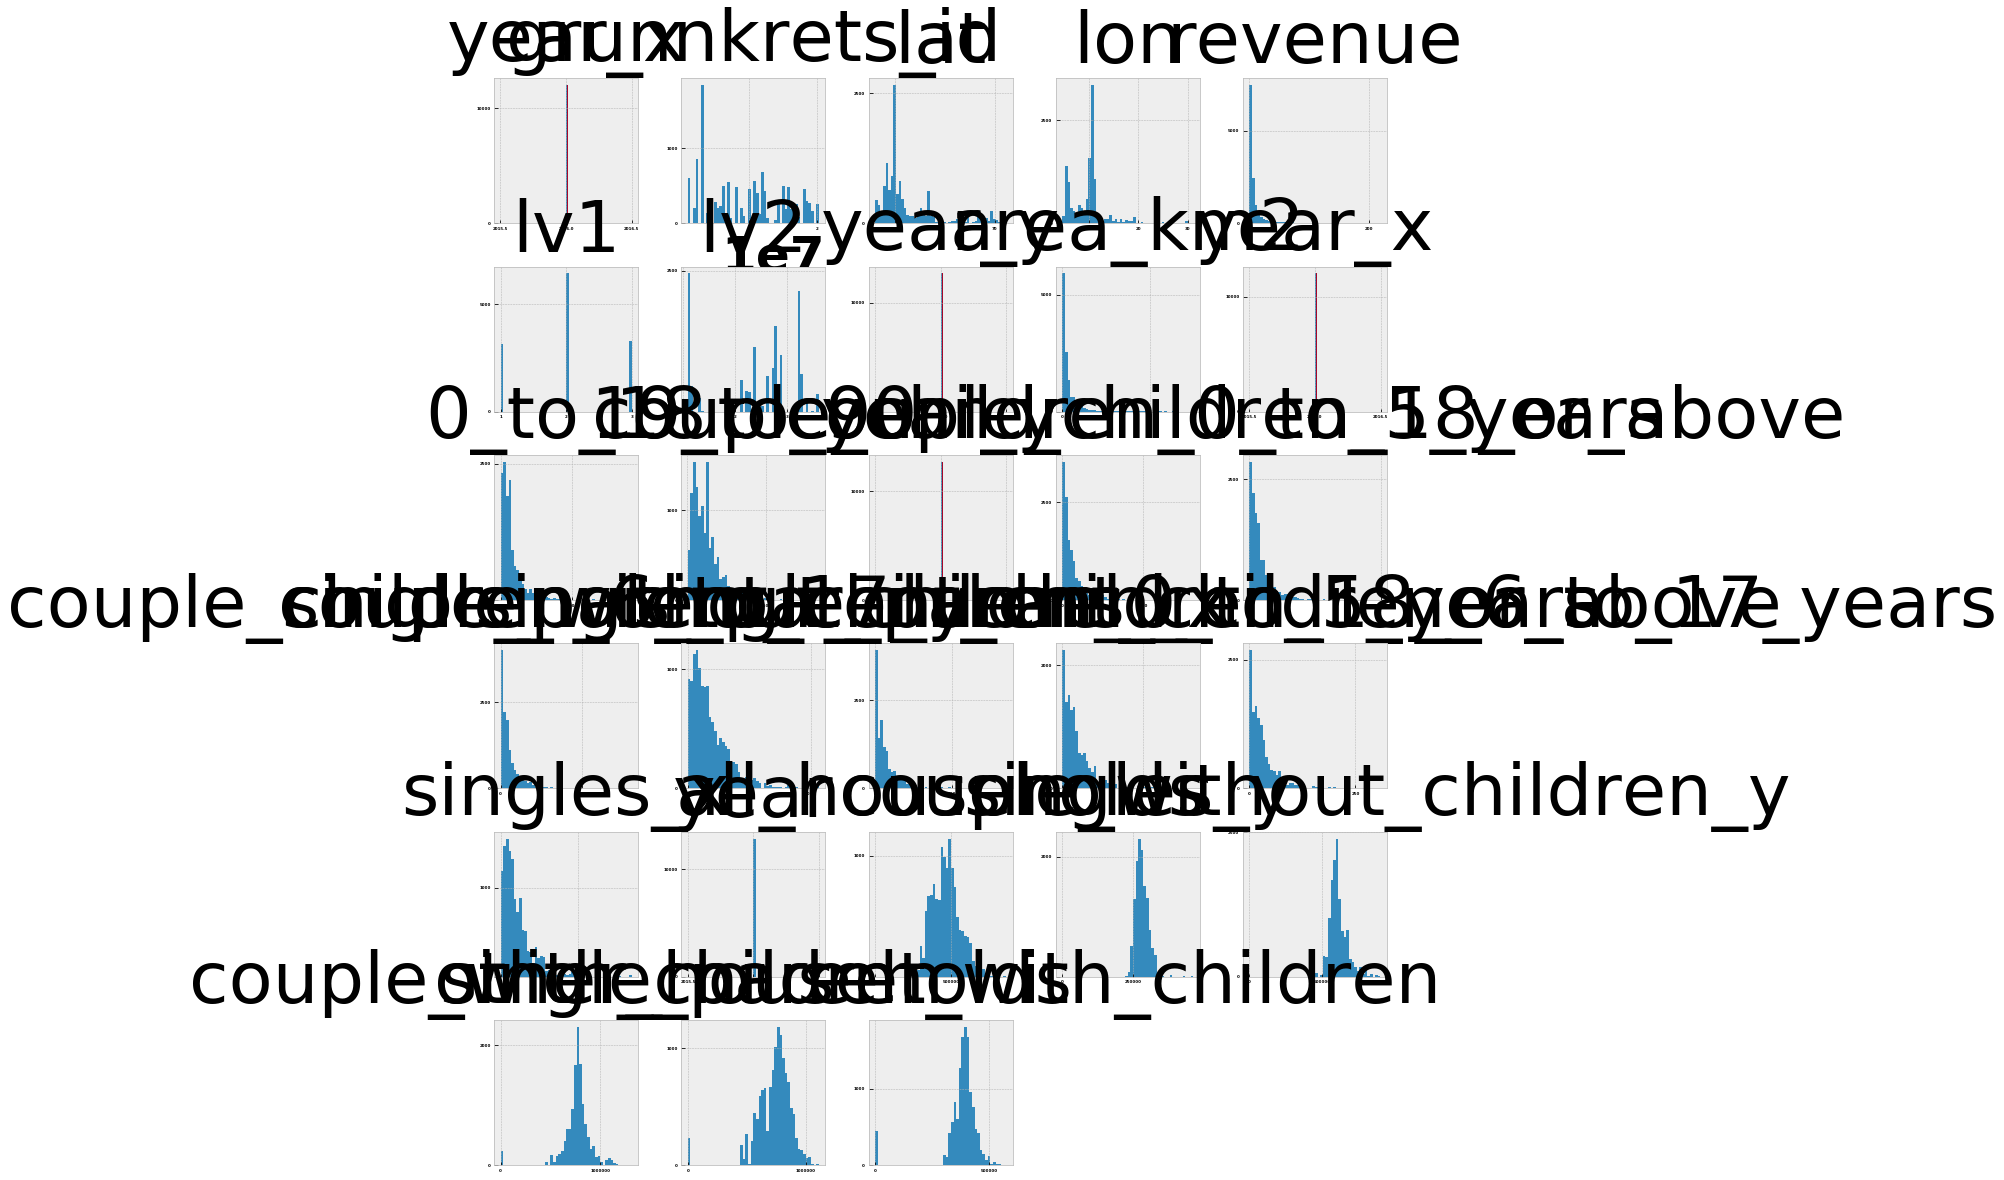

In [16]:
df_numerical_features.hist(figsize=(16, 20), bins=50, xlabelsize=4, ylabelsize=4); 

## Correlation with Revenue

In [339]:
df_num_corr = df_numerical_features.corr()['revenue'][:-1] # -1 because the latest row is SalePrice
df_num_corr
golden_features_list = df_num_corr[abs(df_num_corr) > 0.00].sort_values(ascending=False)
print("The top {} correlated values with revenue are:\n{}".format(len(golden_features_list), golden_features_list))

The top 24 correlated values with revenue are:
revenue                                 1.000000
all_households                          0.037117
singles_y                               0.034573
lv2                                     0.021941
0_to_18                                 0.021079
other_households                        0.020773
couple_children_6_to_17_years           0.016798
couple_with_children                    0.014701
grunnkrets_id                           0.014588
area_km2                                0.013703
couple_children_0_to_5_years            0.012815
couple_without_children_y               0.012283
couple_children_18_or_above             0.011553
single_parent_children_18_or_above      0.011551
distance_from_center                    0.011382
single_parent_children_6_to_17_years    0.008844
lat                                     0.007547
19_to_90                                0.004041
lon                                     0.003112
single_parent_children

# Feature Engineering

## 1. Dropping Redundant Columns

In [340]:
stores_train_finalcols = stores_train_merged.drop(columns=[
    'year_x', 'store_name', 'plaace_hierarchy_id', 'grunnkrets_id', 'address', 'lv1', 'lv2', 'lv3', 'lv4', 'year_y',
    'grunnkrets_name', 'district_name', 'geometry','0_to_18','19_to_90','lon'])

stores_test_finalcols = stores_test_merged.drop(columns=[
    'year_x', 'store_name', 'plaace_hierarchy_id', 'grunnkrets_id', 'address', 'lv1', 'lv2', 'lv3', 'lv4', 'year_y',
    'grunnkrets_name', 'district_name', 'geometry','0_to_18','19_to_90','lon'])


In [293]:
stores_train_finalcols

,store_id,sales_channel_name_x,chain_name,mall_name,revenue,sales_channel_name_y,lv1_desc,lv2_desc,lv3_desc,lv4_desc,distance_from_center,angle,municipality_name,area_km2,couple_children_0_to_5_years,couple_children_18_or_above,couple_children_6_to_17_years,couple_without_children_x,single_parent_children_0_to_5_years,single_parent_children_18_or_above,single_parent_children_6_to_17_years,singles_x,year,all_households,singles_y,couple_without_children_y,couple_with_children,other_households,single_parent_with_children
0,983540538-974187930-44774,Hamburger restaurants,MCDONALDS,Magasinet Drammen,17.998,Hamburger restaurants,Dining and Experiences,Restaurant,Hamburger restaurants,Hamburger restaurants,1.483925,2.999938,Drammen,0.155779,20.0,0.0,8.0,28.0,4.0,6.0,11.0,75.0,2016.0,398700.0,277500.0,669100.0,832800.0,679600.0,349500.0
1,987074191-973117734-44755,Hamburger restaurants,MCDONALDS,NaN,23.828,Hamburger restaurants,Dining and Experiences,Restaurant,Hamburger restaurants,Hamburger restaurants,1.493786,2.624389,Oslo,0.264278,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,2016.0,374800.0,295000.0,679600.0,802200.0,604100.0,397700.0
2,984890265-981157303-64491,Hamburger restaurants,BURGER KING,Kuben Hønefoss,16.099,Hamburger restaurants,Dining and Experiences,Restaurant,Hamburger restaurants,Hamburger restaurants,1.079018,2.898973,Ringerike,0.160152,45.0,9.0,38.0,84.0,13.0,6.0,12.0,150.0,2016.0,347900.0,251900.0,589900.0,673100.0,637600.0,327000.0
3,914057442-992924179-126912,Hamburger restaurants,BURGER KING,Glasshuspassasjen,9.296,Hamburger restaurants,Dining and Experiences,Restaurant,Hamburger restaurants,Hamburger restaurants,7.489049,0.625420,Bodø,0.095029,41.0,10.0,27.0,126.0,11.0,8.0,15.0,254.0,2016.0,394000.0,293600.0,602000.0,675800.0,699600.0,335200.0
4,913018583-913063538-668469,Hamburger restaurants,BURGER KING,Tillertorget,4.528,Hamburger restaurants,Dining and Experiences,Restaurant,Hamburger restaurants,Hamburger restaurants,2.179184,0.174997,Trondheim,0.251070,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2016.0,623700.0,296500.0,635700.0,779700.0,801300.0,413600.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12854,915789943-915806929-781991,Beer and soda shop,NaN,NaN,0.088,Beer and soda shop,Retail,Food and drinks,Alcohol sales,Beer and soda shop,1.860369,2.877541,Horten,0.291337,159.0,53.0,113.0,488.0,46.0,36.0,58.0,556.0,2016.0,381900.0,263600.0,563700.0,682000.0,636800.0,382100.0
12855,917921733-917982368-868081,Beer and soda shop,GULATING GRUPPEN,CC Gjøvik,1.816,Beer and soda shop,Retail,Food and drinks,Alcohol sales,Beer and soda shop,0.810793,2.104077,Gjøvik,0.137188,47.0,9.0,14.0,138.0,5.0,7.0,19.0,256.0,2016.0,292000.0,243200.0,457800.0,465300.0,477700.0,339200.0
12856,911721961-911764474-496764,Beer and soda shop,GULATING GRUPPEN,Strømmen Storsenter,38.225,Beer and soda shop,Retail,Food and drinks,Alcohol sales,Beer and soda shop,1.620608,2.466972,Skedsmo,0.123431,147.0,30.0,76.0,332.0,50.0,30.0,33.0,407.0,2016.0,440200.0,286200.0,595100.0,759300.0,745200.0,359800.0
12857,914337046-914343372-721294,Beer and soda shop,NaN,Bystasjonen,3.642,Beer and soda shop,Retail,Food and drinks,Alcohol sales,Beer and soda shop,4.870736,-2.077065,Sandnes,0.034857,22.0,0.0,7.0,86.0,6.0,0.0,10.0,114.0,2016.0,382400.0,282700.0,597500.0,601500.0,649900.0,361700.0


## 2. One Hot Encoding - Do not need to run this part anymore for LightGBM & CatBoost

### Using LabelEncoder

In [71]:
#categorical data
label_encoder = preprocessing.LabelEncoder()
categorical_cols = ['sales_channel_name_x', 'chain_name', 'municipality_name', 'sales_channel_name_y', 'lv1_desc',
'lv2_desc', 'lv3_desc', 'lv4_desc','mall_name'] 

df_res = stores_train_finalcols.append(stores_test_finalcols)

,store_id,sales_channel_name_x,lat,lon,chain_name,mall_name,revenue,sales_channel_name_y,lv1_desc,lv2_desc,lv3_desc,lv4_desc,municipality_name,area_km2,0_to_18,19_to_90,couple_children_0_to_5_years,couple_children_18_or_above,couple_children_6_to_17_years,couple_without_children_x,single_parent_children_0_to_5_years,single_parent_children_18_or_above,single_parent_children_6_to_17_years,singles_x,year,all_households,singles_y,couple_without_children_y,couple_with_children,other_households,single_parent_with_children
0,983540538-974187930-44774,39,59.743104,10.204928,MCDONALDS,Magasinet Drammen,17.998,Hamburger restaurants,Dining and Experiences,Restaurant,Hamburger restaurants,Hamburger restaurants,Drammen,0.155779,25.000000,132.000000,20.0,0.0,8.0,28.0,4.0,6.0,11.0,75.0,2016.0,398700.0,277500.0,669100.0,832800.0,679600.0,349500.0
1,987074191-973117734-44755,39,59.913759,10.734031,MCDONALDS,NaN,23.828,Hamburger restaurants,Dining and Experiences,Restaurant,Hamburger restaurants,Hamburger restaurants,Oslo,0.264278,143.178518,622.172205,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,2016.0,374800.0,295000.0,679600.0,802200.0,604100.0,397700.0
2,984890265-981157303-64491,39,60.164751,10.254656,BURGER KING,Kuben Hønefoss,16.099,Hamburger restaurants,Dining and Experiences,Restaurant,Hamburger restaurants,Hamburger restaurants,Ringerike,0.160152,67.000000,305.000000,45.0,9.0,38.0,84.0,13.0,6.0,12.0,150.0,2016.0,347900.0,251900.0,589900.0,673100.0,637600.0,327000.0
3,914057442-992924179-126912,39,67.283669,14.379796,BURGER KING,Glasshuspassasjen,9.296,Hamburger restaurants,Dining and Experiences,Restaurant,Hamburger restaurants,Hamburger restaurants,Bodø,0.095029,46.000000,428.000000,41.0,10.0,27.0,126.0,11.0,8.0,15.0,254.0,2016.0,394000.0,293600.0,602000.0,675800.0,699600.0,335200.0
4,913018583-913063538-668469,39,63.358068,10.374832,BURGER KING,Tillertorget,4.528,Hamburger restaurants,Dining and Experiences,Restaurant,Hamburger restaurants,Hamburger restaurants,Trondheim,0.251070,143.178518,622.172205,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2016.0,623700.0,296500.0,635700.0,779700.0,801300.0,413600.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8572,917323003-917383529-844309,5,59.259575,5.325813,GULATING GRUPPEN,NaN,NaN,Beer and soda shop,Retail,Food and drinks,Alcohol sales,Beer and soda shop,Karmøy,1.708924,92.000000,336.000000,56.0,23.0,115.0,120.0,7.0,16.0,14.0,60.0,2016.0,507700.0,264800.0,607300.0,768400.0,785200.0,377800.0
8573,917353379-917411824-845904,5,58.976219,5.721546,NaN,NaN,NaN,Beer and soda shop,Retail,Food and drinks,Alcohol sales,Beer and soda shop,Stavanger,0.310575,90.000000,929.000000,102.0,12.0,47.0,352.0,14.0,8.0,18.0,433.0,2016.0,484900.0,327100.0,669400.0,829500.0,721800.0,418900.0
8574,917072302-917089248-833647,5,59.928330,11.163202,GULATING GRUPPEN,NaN,NaN,Beer and soda shop,Retail,Food and drinks,Alcohol sales,Beer and soda shop,Fet,1.627789,237.000000,1050.000000,200.0,84.0,222.0,316.0,13.0,46.0,65.0,324.0,2016.0,614000.0,295200.0,663400.0,842000.0,866000.0,478900.0
8575,916960557-916993161-829908,5,60.445790,5.161587,NaN,NaN,NaN,Beer and soda shop,Retail,Food and drinks,Alcohol sales,Beer and soda shop,Askøy,1.103012,231.000000,683.000000,202.0,101.0,207.0,178.0,16.0,40.0,34.0,112.0,2016.0,652800.0,282800.0,627300.0,807400.0,849500.0,383500.0


### Using Get_Dummies

In [141]:
#categorical data
categorical_cols = ['sales_channel_name_x', 'chain_name', 'municipality_name', 'sales_channel_name_y', 'lv1_desc',
'lv2_desc', 'lv3_desc', 'lv4_desc','mall_name'] 

df_res = stores_train_finalcols.append(stores_test_finalcols)

#import pandas as pd
df_res_onehot = pd.get_dummies(df_res, columns = categorical_cols)
stores_train_finalcols_onehot = df_res_onehot.iloc[:12859]
stores_test_finalcols_onehot = df_res_onehot.iloc[12859:]

stores_test_finalcols_onehot

store_id        lat        lon  revenue  area_km2  \
2448  951635200-897514982-167862  59.802559   5.819865      NaN  1.082595   
2449   992480939-992524235-98502  58.941515   5.745594      NaN  0.358485   
2450   916749686-974106361-40966  59.687080   9.629682      NaN  0.293455   
2451  995992574-971996641-130780  60.202481   5.447288      NaN  0.901113   
2452  997985613-998000475-427101  59.696582   8.065247      NaN  2.299577   
...                          ...        ...        ...      ...       ...   
8572  917323003-917383529-844309  59.259575   5.325813      NaN  1.708924   
8573  917353379-917411824-845904  58.976219   5.721546      NaN  0.310575   
8574  917072302-917089248-833647  59.928330  11.163202      NaN  1.627789   
8575  916960557-916993161-829908  60.445790   5.161587      NaN  1.103012   
8576   987280891-972040746-45320  59.097903   9.055490      NaN  1.677433   

      0_to_18  19_to_90  couple_children_0_to_5_years  \
2448    100.0     291.0                          67.0   
2449    266.0    1335.0                         229.0   
2450    156.0     722.0                         125.0   
2451    309.0     921.0                         289.0   
2452    125.0     477.0                         102.0   
...       ...       ...                           ...   
8572     92.0     336.0                          56.0   
8573     90.0     929.0                         102.0   
8574    237.0    1050.0                         200.0   
8575    231.0     683.0                         202.0   
8576    299.0    1003.0                         233.0   

      couple_children_18_or_above  couple_children_6_to_17_years  \
2448                         35.0                          106.0   
2449                        103.0                          229.0   
2450                         31.0                          124.0   
2451                         88.0                          208.0   
2452                         73.0                          127.0   
...                           ...                            ...   
8572                         23.0                          115.0   
8573                         12.0                           47.0   
8574                         84.0                          222.0   
8575                        101.0                          207.0   
8576                         75.0                          249.0   

      couple_without_children_x  single_parent_children_0_to_5_years  \
2448                      100.0                                  5.0   
2449                      382.0                                 15.0   
2450                      166.0                                 14.0   
2451                      276.0                                 27.0   
2452                       94.0                                  0.0   
...                         ...                                  ...   
8572                      120.0                                  7.0   
8573                      352.0                                 14.0   
8574                      316.0                                 13.0   
8575                      178.0                                 16.0   
8576                      274.0                                 29.0   

      single_parent_children_18_or_above  \
2448                                 0.0   
2449                                29.0   
2450                                23.0   
2451                                38.0   
2452                                17.0   
...                                  ...   
8572                                16.0   
8573                                 8.0   
8574                                46.0   
8575                                40.0   
8576                                32.0   

      single_parent_children_6_to_17_years  singles_x    year  all_households  \
2448                                  10.0       64.0  2016.0        585200.0   
2449                                  51.

## 3. Handling Outliers

In [158]:
#Dropping the outlier rows with Percentiles - Run this if you are using One Hot Encoder
# upper_lim = stores_train_finalcols_onehot['revenue'].quantile(.95)
# lower_lim = stores_train_finalcols_onehot['revenue'].quantile(.05)

# stores_train_finalcols_onehot = stores_train_finalcols_onehot[(stores_train_finalcols_onehot['revenue'] < upper_lim) & (stores_train_finalcols_onehot['revenue'] > lower_lim)]
# X_train = stores_train_finalcols_onehot.drop(columns=['revenue', 'store_id'])
# y_train = stores_train_finalcols_onehot.revenue 
# X_test = stores_test_finalcols_onehot.drop(columns=['store_id'])
# X_train


In [341]:
#Dropping the outlier rows with Percentiles - Run this if NOT using One Hot Encoder
upper_lim = stores_train_finalcols['revenue'].quantile(.95)
lower_lim = stores_train_finalcols['revenue'].quantile(.05)

stores_train_finalcols = stores_train_finalcols[(stores_train_finalcols['revenue'] < upper_lim) & (stores_train_finalcols['revenue'] > lower_lim)]
X_train = stores_train_finalcols.drop(columns=['revenue', 'store_id'])
y_train = stores_train_finalcols.revenue 
X_test = stores_test_finalcols.drop(columns=['store_id'])

#Imputing missing values for both train and test
X_train.fillna(-999, inplace=True)
X_test.fillna(-999,inplace=True)

categorical_features_indices = np.where(X_train.dtypes != np.float)[0]
categorical_features_indices

array([ 0,  2,  3,  4,  5,  6,  7,  8, 11])

# Models

## Model 1 - catBoost

### Log Revenue Value to Match Loss Function RMSE

In [342]:
y_train_log = np.log(y_train)
y_train_log

0        2.890261
1        3.170861
2        2.778757
3        2.229584
4        1.510280
           ...   
12852    0.064851
12853    1.049772
12855    0.596636
12857    1.292533
12858    0.845010
Name: revenue, Length: 11572, dtype: float64

### Do Internal Split

In [343]:
# Added internal split
from sklearn.model_selection import train_test_split
X_training, X_testing, y_training, y_testing = train_test_split(X_train, y_train_log, train_size=0.8, random_state=123)

In [240]:
import catboost as ctb

In [67]:
best_params = {
            'bagging_temperature': 0.5,
            'depth': 8,
            'iterations': 1000,
            'l2_leaf_reg': 25,
            'learning_rate': 0.05,
            'sampling_frequency': 'PerTreeLevel',
            'leaf_estimation_method': 'Gradient',
            'random_strength': 0.8,
            'boosting_type': 'Ordered',
            'feature_border_type': 'MaxLogSum',
            'l2_leaf_reg': 50,
            'max_ctr_complexity': 2,
            'fold_len_multiplier': 2
    }
model = ctb.CatBoostRegressor(**best_params,
                               loss_function='RMSE',
                               eval_metric='AUC',
                               nan_mode='Min',
                               thread_count=8,
                               task_type='CPU',
                               verbose=False)
model.fit(X_training, y_training, cat_features=categorical_features_indices)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

### Parameter Tuning Using GridSearch

In [344]:
from sklearn.model_selection import GridSearchCV

train_dataset = ctb.Pool(X_training, y_training, cat_features=categorical_features_indices) 
model = ctb.CatBoostRegressor()

#create the grid
grid = {'depth' : [8],
              'learning_rate' : [0.1],
              'iterations'    : [200],
        'l2_leaf_reg': [0.5]}
search_results = model.grid_search(grid, train_dataset, cv=5)
print("\nBest Params : ", search_results['params'])

0:	learn: 1.5213308	test: 1.5392673	best: 1.5392673 (0)	total: 842ms	remaining: 2m 47s
1:	learn: 1.4360293	test: 1.4484291	best: 1.4484291 (1)	total: 1.03s	remaining: 1m 41s
2:	learn: 1.3650475	test: 1.3753258	best: 1.3753258 (2)	total: 1.12s	remaining: 1m 13s
3:	learn: 1.3020254	test: 1.3085825	best: 1.3085825 (3)	total: 1.17s	remaining: 57.3s
4:	learn: 1.2477107	test: 1.2495649	best: 1.2495649 (4)	total: 1.72s	remaining: 1m 7s
5:	learn: 1.2019358	test: 1.2005508	best: 1.2005508 (5)	total: 1.78s	remaining: 57.5s
6:	learn: 1.1633062	test: 1.1601922	best: 1.1601922 (6)	total: 2.04s	remaining: 56.1s
7:	learn: 1.1304297	test: 1.1257068	best: 1.1257068 (7)	total: 2.15s	remaining: 51.6s
8:	learn: 1.1028067	test: 1.0964472	best: 1.0964472 (8)	total: 2.28s	remaining: 48.4s
9:	learn: 1.0814387	test: 1.0737607	best: 1.0737607 (9)	total: 2.63s	remaining: 50s
10:	learn: 1.0618644	test: 1.0526260	best: 1.0526260 (10)	total: 2.76s	remaining: 47.5s
11:	learn: 1.0428768	test: 1.0348633	best: 1.034863

96:	learn: 0.8419806	test: 0.9290249	best: 0.9278618 (87)	total: 13.8s	remaining: 14.6s
97:	learn: 0.8414360	test: 0.9291118	best: 0.9278618 (87)	total: 14.1s	remaining: 14.6s
98:	learn: 0.8400430	test: 0.9290305	best: 0.9278618 (87)	total: 14.1s	remaining: 14.4s
99:	learn: 0.8382961	test: 0.9295346	best: 0.9278618 (87)	total: 14.1s	remaining: 14.1s
100:	learn: 0.8376486	test: 0.9299747	best: 0.9278618 (87)	total: 14.2s	remaining: 13.9s
101:	learn: 0.8360162	test: 0.9297598	best: 0.9278618 (87)	total: 14.3s	remaining: 13.7s
102:	learn: 0.8342421	test: 0.9303033	best: 0.9278618 (87)	total: 14.3s	remaining: 13.5s
103:	learn: 0.8328189	test: 0.9306634	best: 0.9278618 (87)	total: 14.4s	remaining: 13.3s
104:	learn: 0.8318950	test: 0.9307422	best: 0.9278618 (87)	total: 14.5s	remaining: 13.1s
105:	learn: 0.8312051	test: 0.9306357	best: 0.9278618 (87)	total: 14.5s	remaining: 12.9s
106:	learn: 0.8301739	test: 0.9306267	best: 0.9278618 (87)	total: 14.6s	remaining: 12.7s
107:	learn: 0.8288287	tes

189:	learn: 0.7367691	test: 0.9347771	best: 0.9278618 (87)	total: 20.8s	remaining: 1.09s
190:	learn: 0.7350662	test: 0.9352465	best: 0.9278618 (87)	total: 20.8s	remaining: 982ms
191:	learn: 0.7343308	test: 0.9355205	best: 0.9278618 (87)	total: 21.1s	remaining: 877ms
192:	learn: 0.7335995	test: 0.9354281	best: 0.9278618 (87)	total: 21.1s	remaining: 765ms
193:	learn: 0.7329340	test: 0.9355214	best: 0.9278618 (87)	total: 21.1s	remaining: 654ms
194:	learn: 0.7319842	test: 0.9354489	best: 0.9278618 (87)	total: 21.2s	remaining: 543ms
195:	learn: 0.7312619	test: 0.9355436	best: 0.9278618 (87)	total: 21.2s	remaining: 433ms
196:	learn: 0.7304546	test: 0.9356256	best: 0.9278618 (87)	total: 21.3s	remaining: 324ms
197:	learn: 0.7301668	test: 0.9356644	best: 0.9278618 (87)	total: 21.3s	remaining: 215ms
198:	learn: 0.7289601	test: 0.9359669	best: 0.9278618 (87)	total: 21.4s	remaining: 107ms
199:	learn: 0.7280148	test: 0.9357286	best: 0.9278618 (87)	total: 21.4s	remaining: 0us

bestTest = 0.927861770

82:	learn: 0.8585088	test: 0.9481142	best: 0.9474275 (78)	total: 7.2s	remaining: 10.1s
83:	learn: 0.8577258	test: 0.9478109	best: 0.9474275 (78)	total: 7.29s	remaining: 10.1s
84:	learn: 0.8561057	test: 0.9474797	best: 0.9474275 (78)	total: 7.49s	remaining: 10.1s
85:	learn: 0.8547979	test: 0.9475123	best: 0.9474275 (78)	total: 7.53s	remaining: 9.98s
86:	learn: 0.8530575	test: 0.9472439	best: 0.9472439 (86)	total: 7.59s	remaining: 9.86s
87:	learn: 0.8508783	test: 0.9472983	best: 0.9472439 (86)	total: 7.64s	remaining: 9.72s
88:	learn: 0.8492714	test: 0.9477794	best: 0.9472439 (86)	total: 7.71s	remaining: 9.62s
89:	learn: 0.8483816	test: 0.9474535	best: 0.9472439 (86)	total: 7.83s	remaining: 9.57s
90:	learn: 0.8467815	test: 0.9474099	best: 0.9472439 (86)	total: 7.88s	remaining: 9.44s
91:	learn: 0.8448562	test: 0.9479849	best: 0.9472439 (86)	total: 7.95s	remaining: 9.34s
92:	learn: 0.8434927	test: 0.9477939	best: 0.9472439 (86)	total: 8.06s	remaining: 9.27s
93:	learn: 0.8422369	test: 0.9479

176:	learn: 0.7429593	test: 0.9515976	best: 0.9463667 (99)	total: 13.1s	remaining: 1.7s
177:	learn: 0.7421232	test: 0.9515974	best: 0.9463667 (99)	total: 13.2s	remaining: 1.64s
178:	learn: 0.7412329	test: 0.9514289	best: 0.9463667 (99)	total: 13.3s	remaining: 1.56s
179:	learn: 0.7407748	test: 0.9513381	best: 0.9463667 (99)	total: 13.3s	remaining: 1.48s
180:	learn: 0.7396170	test: 0.9511162	best: 0.9463667 (99)	total: 13.4s	remaining: 1.41s
181:	learn: 0.7385008	test: 0.9513484	best: 0.9463667 (99)	total: 13.4s	remaining: 1.33s
182:	learn: 0.7375147	test: 0.9516644	best: 0.9463667 (99)	total: 13.5s	remaining: 1.25s
183:	learn: 0.7366796	test: 0.9518519	best: 0.9463667 (99)	total: 13.6s	remaining: 1.18s
184:	learn: 0.7361389	test: 0.9518277	best: 0.9463667 (99)	total: 13.6s	remaining: 1.1s
185:	learn: 0.7349107	test: 0.9517347	best: 0.9463667 (99)	total: 13.7s	remaining: 1.03s
186:	learn: 0.7338172	test: 0.9518599	best: 0.9463667 (99)	total: 13.7s	remaining: 952ms
187:	learn: 0.7325751	t

70:	learn: 0.8743094	test: 0.9407454	best: 0.9406843 (69)	total: 4.3s	remaining: 7.81s
71:	learn: 0.8732455	test: 0.9407389	best: 0.9406843 (69)	total: 4.34s	remaining: 7.72s
72:	learn: 0.8716744	test: 0.9404716	best: 0.9404716 (72)	total: 4.39s	remaining: 7.63s
73:	learn: 0.8705067	test: 0.9404364	best: 0.9404364 (73)	total: 4.44s	remaining: 7.56s
74:	learn: 0.8691612	test: 0.9405678	best: 0.9404364 (73)	total: 4.55s	remaining: 7.58s
75:	learn: 0.8673901	test: 0.9404337	best: 0.9404337 (75)	total: 4.59s	remaining: 7.49s
76:	learn: 0.8670010	test: 0.9403643	best: 0.9403643 (76)	total: 4.63s	remaining: 7.39s
77:	learn: 0.8657132	test: 0.9403698	best: 0.9403643 (76)	total: 4.69s	remaining: 7.34s
78:	learn: 0.8643365	test: 0.9402999	best: 0.9402999 (78)	total: 4.83s	remaining: 7.39s
79:	learn: 0.8633699	test: 0.9403177	best: 0.9402999 (78)	total: 4.9s	remaining: 7.36s
80:	learn: 0.8623010	test: 0.9407623	best: 0.9402999 (78)	total: 4.94s	remaining: 7.26s
81:	learn: 0.8607778	test: 0.94101

162:	learn: 0.7632038	test: 0.9437117	best: 0.9373095 (102)	total: 13.3s	remaining: 3.01s
163:	learn: 0.7625342	test: 0.9436931	best: 0.9373095 (102)	total: 13.4s	remaining: 2.94s
164:	learn: 0.7606569	test: 0.9439160	best: 0.9373095 (102)	total: 13.5s	remaining: 2.86s
165:	learn: 0.7601211	test: 0.9440484	best: 0.9373095 (102)	total: 13.5s	remaining: 2.77s
166:	learn: 0.7591941	test: 0.9446729	best: 0.9373095 (102)	total: 13.6s	remaining: 2.69s
167:	learn: 0.7584913	test: 0.9446634	best: 0.9373095 (102)	total: 14.2s	remaining: 2.7s
168:	learn: 0.7576257	test: 0.9450376	best: 0.9373095 (102)	total: 14.4s	remaining: 2.64s
169:	learn: 0.7567481	test: 0.9452515	best: 0.9373095 (102)	total: 14.5s	remaining: 2.57s
170:	learn: 0.7555306	test: 0.9451302	best: 0.9373095 (102)	total: 14.6s	remaining: 2.48s
171:	learn: 0.7544428	test: 0.9453571	best: 0.9373095 (102)	total: 14.7s	remaining: 2.39s
172:	learn: 0.7535526	test: 0.9455154	best: 0.9373095 (102)	total: 14.7s	remaining: 2.3s
173:	learn: 

55:	learn: 0.8874468	test: 0.9397499	best: 0.9397499 (55)	total: 4.14s	remaining: 10.6s
56:	learn: 0.8866342	test: 0.9396973	best: 0.9396973 (56)	total: 4.19s	remaining: 10.5s
57:	learn: 0.8849898	test: 0.9390746	best: 0.9390746 (57)	total: 4.23s	remaining: 10.4s
58:	learn: 0.8829041	test: 0.9385792	best: 0.9385792 (58)	total: 4.34s	remaining: 10.4s
59:	learn: 0.8806265	test: 0.9391334	best: 0.9385792 (58)	total: 4.4s	remaining: 10.3s
60:	learn: 0.8785782	test: 0.9393747	best: 0.9385792 (58)	total: 4.48s	remaining: 10.2s
61:	learn: 0.8763779	test: 0.9395589	best: 0.9385792 (58)	total: 4.6s	remaining: 10.2s
62:	learn: 0.8739147	test: 0.9392152	best: 0.9385792 (58)	total: 4.67s	remaining: 10.2s
63:	learn: 0.8720225	test: 0.9391748	best: 0.9385792 (58)	total: 4.78s	remaining: 10.1s
64:	learn: 0.8710112	test: 0.9391463	best: 0.9385792 (58)	total: 4.94s	remaining: 10.3s
65:	learn: 0.8695887	test: 0.9393811	best: 0.9385792 (58)	total: 5.03s	remaining: 10.2s
66:	learn: 0.8684431	test: 0.93955

148:	learn: 0.7578194	test: 0.9470263	best: 0.9383118 (91)	total: 11.5s	remaining: 3.94s
149:	learn: 0.7568333	test: 0.9473448	best: 0.9383118 (91)	total: 11.6s	remaining: 3.85s
150:	learn: 0.7558319	test: 0.9472747	best: 0.9383118 (91)	total: 11.6s	remaining: 3.76s
151:	learn: 0.7550301	test: 0.9474966	best: 0.9383118 (91)	total: 11.7s	remaining: 3.68s
152:	learn: 0.7545431	test: 0.9475141	best: 0.9383118 (91)	total: 11.8s	remaining: 3.61s
153:	learn: 0.7531043	test: 0.9479845	best: 0.9383118 (91)	total: 11.8s	remaining: 3.53s
154:	learn: 0.7515882	test: 0.9477359	best: 0.9383118 (91)	total: 11.9s	remaining: 3.44s
155:	learn: 0.7508838	test: 0.9480360	best: 0.9383118 (91)	total: 11.9s	remaining: 3.36s
156:	learn: 0.7500535	test: 0.9478982	best: 0.9383118 (91)	total: 12s	remaining: 3.29s
157:	learn: 0.7493124	test: 0.9479265	best: 0.9383118 (91)	total: 12s	remaining: 3.2s
158:	learn: 0.7481624	test: 0.9486394	best: 0.9383118 (91)	total: 12.1s	remaining: 3.12s
159:	learn: 0.7471145	test

45:	learn: 0.8924504	test: 0.9681342	best: 0.9680304 (44)	total: 3.4s	remaining: 11.4s
46:	learn: 0.8920229	test: 0.9680561	best: 0.9680304 (44)	total: 3.66s	remaining: 11.9s
47:	learn: 0.8906656	test: 0.9681551	best: 0.9680304 (44)	total: 3.74s	remaining: 11.9s
48:	learn: 0.8889142	test: 0.9673331	best: 0.9673331 (48)	total: 3.82s	remaining: 11.8s
49:	learn: 0.8870574	test: 0.9670947	best: 0.9670947 (49)	total: 3.96s	remaining: 11.9s
50:	learn: 0.8849671	test: 0.9668016	best: 0.9668016 (50)	total: 4.01s	remaining: 11.7s
51:	learn: 0.8842724	test: 0.9667724	best: 0.9667724 (51)	total: 4.12s	remaining: 11.7s
52:	learn: 0.8826025	test: 0.9666736	best: 0.9666736 (52)	total: 4.23s	remaining: 11.7s
53:	learn: 0.8815653	test: 0.9664467	best: 0.9664467 (53)	total: 4.28s	remaining: 11.6s
54:	learn: 0.8798448	test: 0.9660641	best: 0.9660641 (54)	total: 4.35s	remaining: 11.5s
55:	learn: 0.8784687	test: 0.9659453	best: 0.9659453 (55)	total: 4.41s	remaining: 11.3s
56:	learn: 0.8771716	test: 0.9655

139:	learn: 0.7677320	test: 0.9685787	best: 0.9631407 (82)	total: 12.4s	remaining: 5.33s
140:	learn: 0.7672138	test: 0.9687711	best: 0.9631407 (82)	total: 12.5s	remaining: 5.24s
141:	learn: 0.7663561	test: 0.9687871	best: 0.9631407 (82)	total: 12.8s	remaining: 5.21s
142:	learn: 0.7653082	test: 0.9685695	best: 0.9631407 (82)	total: 12.8s	remaining: 5.1s
143:	learn: 0.7635762	test: 0.9683681	best: 0.9631407 (82)	total: 12.9s	remaining: 5s
144:	learn: 0.7628019	test: 0.9683820	best: 0.9631407 (82)	total: 12.9s	remaining: 4.9s
145:	learn: 0.7614988	test: 0.9687112	best: 0.9631407 (82)	total: 13s	remaining: 4.8s
146:	learn: 0.7598141	test: 0.9691952	best: 0.9631407 (82)	total: 13s	remaining: 4.7s
147:	learn: 0.7591127	test: 0.9696436	best: 0.9631407 (82)	total: 13.1s	remaining: 4.61s
148:	learn: 0.7575370	test: 0.9706448	best: 0.9631407 (82)	total: 13.3s	remaining: 4.54s
149:	learn: 0.7571661	test: 0.9707496	best: 0.9631407 (82)	total: 13.3s	remaining: 4.45s
150:	learn: 0.7564286	test: 0.97

35:	learn: 0.9250259	test: 0.9400927	best: 0.9400927 (35)	total: 2.58s	remaining: 11.8s
36:	learn: 0.9234815	test: 0.9392529	best: 0.9392529 (36)	total: 2.65s	remaining: 11.7s
37:	learn: 0.9219141	test: 0.9380181	best: 0.9380181 (37)	total: 2.73s	remaining: 11.7s
38:	learn: 0.9205674	test: 0.9379351	best: 0.9379351 (38)	total: 2.77s	remaining: 11.4s
39:	learn: 0.9187722	test: 0.9376357	best: 0.9376357 (39)	total: 2.84s	remaining: 11.4s
40:	learn: 0.9171622	test: 0.9365923	best: 0.9365923 (40)	total: 2.9s	remaining: 11.3s
41:	learn: 0.9154251	test: 0.9360970	best: 0.9360970 (41)	total: 2.96s	remaining: 11.1s
42:	learn: 0.9137462	test: 0.9355254	best: 0.9355254 (42)	total: 3s	remaining: 11s
43:	learn: 0.9122011	test: 0.9352852	best: 0.9352852 (43)	total: 3.06s	remaining: 10.8s
44:	learn: 0.9103794	test: 0.9344241	best: 0.9344241 (44)	total: 3.1s	remaining: 10.7s
45:	learn: 0.9089239	test: 0.9336916	best: 0.9336916 (45)	total: 3.14s	remaining: 10.5s
46:	learn: 0.9079575	test: 0.9338434	be

129:	learn: 0.7966831	test: 0.9299643	best: 0.9296871 (120)	total: 9.44s	remaining: 5.08s
130:	learn: 0.7949018	test: 0.9295044	best: 0.9295044 (130)	total: 9.49s	remaining: 5s
131:	learn: 0.7926118	test: 0.9296686	best: 0.9295044 (130)	total: 9.55s	remaining: 4.92s
132:	learn: 0.7911049	test: 0.9299993	best: 0.9295044 (130)	total: 9.66s	remaining: 4.87s
133:	learn: 0.7888769	test: 0.9303518	best: 0.9295044 (130)	total: 9.76s	remaining: 4.81s
134:	learn: 0.7881407	test: 0.9305978	best: 0.9295044 (130)	total: 9.82s	remaining: 4.73s
135:	learn: 0.7868928	test: 0.9305176	best: 0.9295044 (130)	total: 9.87s	remaining: 4.65s
136:	learn: 0.7857344	test: 0.9305406	best: 0.9295044 (130)	total: 9.93s	remaining: 4.57s
137:	learn: 0.7845927	test: 0.9305362	best: 0.9295044 (130)	total: 10s	remaining: 4.5s
138:	learn: 0.7835283	test: 0.9308715	best: 0.9295044 (130)	total: 10.2s	remaining: 4.46s
139:	learn: 0.7824145	test: 0.9307316	best: 0.9295044 (130)	total: 10.2s	remaining: 4.37s
140:	learn: 0.78

### Using the parameters from GridSearch

In [112]:
best_params = {'depth': 8, 'iterations': 200, 'learning_rate': 0.1, 'l2_leaf_reg': 0.5}
model = ctb.CatBoostRegressor(**best_params,
                               loss_function='RMSE',
                               nan_mode='Min',
                               thread_count=8,
                               task_type='CPU',
                               verbose=False)
model.fit(X_training, y_training, eval_set=(X_testing, y_testing), cat_features=categorical_features_indices, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [345]:
y_train_pred = model.predict(X_training)
y_train_pred[y_train_pred<0] = 0
y_train_pred

#Added
y_test_pred = model.predict(X_testing)
y_test_pred[y_test_pred<0] = 0
y_test_pred

array([1.95046604, 2.84671626, 0.61880971, ..., 2.36259299, 0.84665813,
       0.98759519])

### Reverse log the predictions

In [346]:
y_training = np.exp(y_training)
y_testing = np.exp(y_testing)
y_train_pred = np.exp(y_train_pred)
y_test_pred = np.exp(y_test_pred)

In [347]:
print(f'Train set RMSLE: {rmsle(y_training, y_train_pred) :.4f}')
print(f'Test set RMSLE: {rmsle(y_testing, y_test_pred) :.4f}')

Train set RMSLE: 0.5464
Test set RMSLE: 0.6508


### Predict for X_test

In [348]:
y_test_pred = model.predict(X_test) 
y_test_pred

array([1.38213432, 1.50607519, 0.8612047 , ..., 1.74667424, 0.9506246 ,
       0.95029538])

In [349]:
y_test_pred_original_values = np.exp(y_test_pred)

### Save Predictions

In [276]:
submission = pd.DataFrame()
submission['id'] = stores_test_finalcols.store_id 
submission['predicted'] = np.asarray(y_test_pred_original_values)

# Save it to disk (`index=False` means don't save the index in the csv)
submission.to_csv('submission_37.csv', index=False)
submission

,id,predicted
0,914206820-914239427-717245,3.628983
1,916789157-916823770-824309,5.000352
2,913341082-977479363-2948,2.150365
3,889682582-889697172-28720,4.476823
4,997991699-998006945-417222,5.738642
...,...,...
8572,917323003-917383529-844309,5.732374
8573,917353379-917411824-845904,2.871324
8574,917072302-917089248-833647,6.382635
8575,916960557-916993161-829908,2.722649


### Feature Importance

In [248]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(200, 200))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')


Text(0.5, 1.0, 'Feature Importance')

## Model 2 - XGBoost

In [206]:
import xgboost as xg

In [ ]:
# Instantiation
xgb_r = xg.XGBRegressor(objective ='reg:linear',
                  n_estimators = 10, seed = 123)
  
# Fitting the model
xgb_r.fit(X_train, y_train)
  
# Predict the model
pred = xgb_r.predict(X_test)

In [ ]:
submission = pd.DataFrame()
submission['id'] = stores_test_finalcols_onehot.store_id 
submission['predicted'] = np.asarray(pred)

# Save it to disk (`index=False` means don't save the index in the csv)
submission.to_csv('submission_6.csv', index=False)
submission

## Model 3 - LightGBM

In [28]:
import lightgbm as lgb

ModuleNotFoundError: No module named 'lightgbm'

In [29]:
# Added internal split
from sklearn.model_selection import train_test_split
X_training, X_testing, y_training, y_testing = train_test_split(X_train, y_train, train_size=0.9, random_state=123)

In [217]:
# X_training, X_testing, y_training, y_testing
# X_test
y_testing

8651      4.762
9097      4.030
5018      0.653
4371      0.587
4872     17.377
          ...  
5036      6.967
5702      4.752
7035     15.657
5763      9.397
12652     0.588
Name: revenue, Length: 1042, dtype: float64

### Transform categorical features into the appropriate type that is expected by LightGBM.

In [218]:
for c in X_training.columns:
    col_type = X_training[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        X_training[c] = X_training[c].astype('category')

for c in X_testing.columns:
    col_type = X_testing[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        X_testing[c] = X_testing[c].astype('category')

for c in X_test.columns:
    col_type = X_test[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        X_test[c] = X_test[c].astype('category')

/tmp/ipykernel_940718/2152689381.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_training[c] = X_training[c].astype('category')
/tmp/ipykernel_940718/2152689381.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_testing[c] = X_testing[c].astype('category')


In [219]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'l1'},
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

In [220]:
# create dataset for lightgbm
lgb_train = lgb.Dataset(X_training, y_training)
lgb_eval = lgb.Dataset(X_testing, y_testing, reference=lgb_train)

In [221]:
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=20,
                valid_sets=lgb_eval,
                callbacks=[lgb.early_stopping(stopping_rounds=5)])

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000802 seconds.
You can set `force_col_wise=true` to remove the overhead.
Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[20]	valid_0's l1: 2.76745	valid_0's l2: 13.5393


/lhome/tbfiora/.local/lib/python3.10/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/lhome/tbfiora/.local/lib/python3.10/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


In [224]:
y_train_pred = gbm.predict(X_training, num_iteration=gbm.best_iteration)
y_test_pred = gbm.predict(X_testing, num_iteration=gbm.best_iteration)

y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)

In [225]:
y_pred

array([5.06129161, 7.86470303, 6.09196628, ..., 6.11361056, 4.30811014,
       3.95665463])

In [226]:
print(f'Train set RMSLE: {rmsle(y_training, y_train_pred) :.4f}')
print(f'Test set RMSLE: {rmsle(y_testing, y_test_pred) :.4f}')

Train set RMSLE: 0.6220
Test set RMSLE: 0.6525


In [227]:
submission = pd.DataFrame()
submission['id'] = stores_test_finalcols.store_id 
submission['predicted'] = np.asarray(y_pred)

# Save it to disk (`index=False` means don't save the index in the csv)
submission.to_csv('submission_21.csv', index=False)
submission

,id,predicted
0,914206820-914239427-717245,5.061292
1,916789157-916823770-824309,7.864703
2,913341082-977479363-2948,6.091966
3,889682582-889697172-28720,7.812610
4,997991699-998006945-417222,6.852076
...,...,...
8572,917323003-917383529-844309,6.291849
8573,917353379-917411824-845904,5.248304
8574,917072302-917089248-833647,6.113611
8575,916960557-916993161-829908,4.308110
